# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tag pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre à la modélisation supervisée et non supervisée de la recommandation de tags. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
import re, spacy, nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from string import punctuation

# no recognition of dependency labels and named entities 
nlp = spacy.load('en', disable=['parser', 'ner'])   
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)

# Déclaration de variables 
data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

In [5]:
# CHARGEMENT
with open('alltags_counter.pkl', 'rb') as f:
    alltags_counter = pickle.load(f) 
with open('ignore_words.pkl', 'rb') as f:
    ignore_words = pickle.load(f) 
with open('specialtags.pkl', 'rb') as f:
    specialtags = pickle.load(f) 
with open('manual_stopwords.pkl', 'rb') as f:
    manual_stopwords = pickle.load(f) 

auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))

posts_topntags_3labels = pd.read_pickle("./posts_topntags_3labels.pkl")
posts_body_clean = pd.read_pickle("./posts_body_clean.pkl")

# Préparation des données pour modélisation

### Scénario top 100 tags et 3 tags par post

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
def model_preprocessing(tags, body):
    
    # Binarizing the tags for the supervised models
    mlb = MultiLabelBinarizer()
    Y_target = mlb.fit_transform(tags)
    
    # 80/20 split
    X_train, X_test, Y_train, Y_test = train_test_split(body.loc[tags.index], 
                                                        Y_target, 
                                                        test_size=0.2, train_size=0.8, random_state=42)
    
    tfidf = TfidfVectorizer(analyzer='word', 
                            encoding='utf-8', 
                            token_pattern=r'(?u)\S+', 
                            max_features=500)
    
    # TF-IDF matrices
    # la littérature recommande de ne pas standardiser un TDIDF
    X_tfidf_train = tfidf.fit_transform(X_train)
    X_tfidf_test = tfidf.transform(X_test)

    return mlb, tfidf, X_tfidf_train, Y_train, X_tfidf_test, Y_test

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

#parameters = {
#    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
#    'estimator__fit_prior' : [True, False]
#}

# Binarizing the tags for the supervised models
mlb = MultiLabelBinarizer()
Y_target = mlb.fit_transform(posts_topntags_3labels)
    
# 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(posts_body_clean.loc[posts_topntags_3labels.index], 
                                                    Y_target, 
                                                    test_size=0.2, train_size=0.8, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', encoding='utf-8', token_pattern=r'(?u)\S+')),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', penalty='l1', random_state=42)))])
     
parameters = {
    'tfidf__min_df': (0.0, 0.05),
    'tfidf__max_df': (0.75, 1.0),    
    'tfidf__max_features': (1000, None),             
    #'clf__estimator__alpha': (0.001, 0.01, 0.1)
    'clf__estimator__C': (1, 10, 100)
}

grid_search_tune = GridSearchCV(pipeline, parameters, scoring='jaccard_weighted', n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, Y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)
print (grid_search_tune.best_params_, grid_search_tune.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 100.8min finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75, max_features=None,
                min_df=0.0, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\S+', tokenizer=None,
                use_idf=True, vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                     

In [9]:
mlb, tfidf, X_tfidf_train, Y_train, X_tfidf_test, Y_test = model_preprocessing(posts_topntags_3labels, posts_body_clean)

In [10]:
# SAUVEGARDE
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)    

In [11]:
tfidf.get_feature_names()

['ability',
 'access',
 'account',
 'action',
 'address',
 'advantage',
 'advice',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'alternative',
 'apache',
 'api',
 'app',
 'append',
 'application',
 'architecture',
 'area',
 'arg',
 'argument',
 'array',
 'arrays',
 'article',
 'aspx',
 'aspxyzspecialtags1zyx',
 'assembly',
 'attempt',
 'attribute',
 'authentication',
 'author',
 'auto',
 'avoid',
 'b',
 'background',
 'bar',
 'base',
 'bash',
 'behavior',
 'benefit',
 'bit',
 'block',
 'blog',
 'body',
 'book',
 'boost',
 'border',
 'box',
 'branch',
 'break',
 'browser',
 'buffer',
 'bug',
 'build',
 'building',
 'business',
 'button',
 'byte',
 'c',
 'call',
 'case',
 'catch',
 'category',
 'cause',
 'cell',
 'character',
 'child',
 'choice',
 'class',
 'click',
 'client',
 'code',
 'collection',
 'color',
 'column',
 'com',
 'combination',
 'command',
 'commit',
 'company',
 'compile',
 'compiler',
 'component',
 'computer',
 'concept',
 'condition',
 'config',
 'configuration',
 'conn

# Recommandation de tags
### Approche non supervisée

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

In [13]:
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

Extracting topics from LDA...


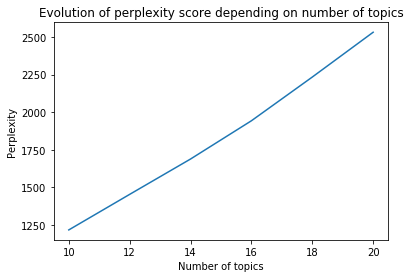

In [14]:
import matplotlib.pyplot as plt

best_perplexity = np.inf
best_lda = 0
perplexity_list = []
n_topics_list = []
lda_model_list = []

print("Extracting topics from LDA...")

# number of topics 
for n_topics in np.linspace(10, 20, 6, dtype='int'):
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, n_jobs=-1, random_state=42).fit(X_tfidf_train)
    n_topics_list.append(n_topics)
    perplexity = lda_model.perplexity(X_tfidf_test)
    perplexity_list.append(perplexity)
    lda_model_list.append(lda_model)

    # Perplexity is defined as exp(-1. * log-likelihood per word)
    # Perplexity: The smaller the better
    if perplexity <= best_perplexity:
        best_perplexity = perplexity
        best_lda = lda_model
                                
plt.title("Evolution of perplexity score depending on number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.plot(n_topics_list, perplexity_list)
plt.style.use('fivethirtyeight')
plt.show()

In [15]:
n_top_words = 10
display_topics(lda_model_list[4], tfidf.get_feature_names(), n_top_words)

Topic 0:
xyzspecialtags2zyx excel model library function sharepoint jar compiler regex class
Topic 1:
service web application windows exception system xyzspecialtags1zyx server error studio
Topic 2:
string character text c value byte output print algorithm function
Topic 3:
form property jquery value tag type dialog input class option
Topic 4:
java javascript application flash shell console icon windows ajax library
Topic 5:
python performance linq emacs nhibernate framework time application web entity
Topic 6:
date datetime time sql day year month statement server transaction
Topic 7:
event view events process controller component control socket application assembly
Topic 8:
svn unit repository version tool source subversion wpf control resource
Topic 9:
database sql server xml table mysql procedure email oracle datum
Topic 10:
item array function element color list perl script loop cookie
Topic 11:
table image column row value height record query delphi datum
Topic 12:
page html http

In [16]:
# SAUVEGARDE
with open('lda_model_list.pkl', 'wb') as f:
    pickle.dump(lda_model_list, f)

In [16]:
#import pyLDAvis.sklearn 
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(best_lda, X_tfidf_test_topntags, tfidf_topntags, mds='tsne')
#panel

### Approche supervisée

In [17]:
def n_tags_by_labels(data, data_label):
    import matplotlib.pyplot as plt
    # Nombre de tags par document
    Y_n_tags = np.sum(data,axis=1)
    # Fréquence du nombre de tags par document
    import collections
    multiLabel_counts = collections.Counter(Y_n_tags)
    # clés 
    # print([x[0] for x in multiLabel_counts.most_common()])
    # valeurs 
    # print([x[1] for x in multiLabel_counts.most_common()])
    plt.figure(figsize=(15,5))
    ax = sns.barplot([x[0] for x in multiLabel_counts.most_common()], [x[1] for x in multiLabel_counts.most_common()])
    plt.title("Questions having multiple tags : {}".format(data_label), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    plt.ylabel('Number of questions', fontsize=18)
    plt.xlabel('Number of tags', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = [x[1] for x in multiLabel_counts.most_common()] / np.sum([x[1] for x in multiLabel_counts.most_common()]) 
    labels = ["{:0.1%}".format(x) for x in labels]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)      
    plt.style.use('fivethirtyeight')        
    return 

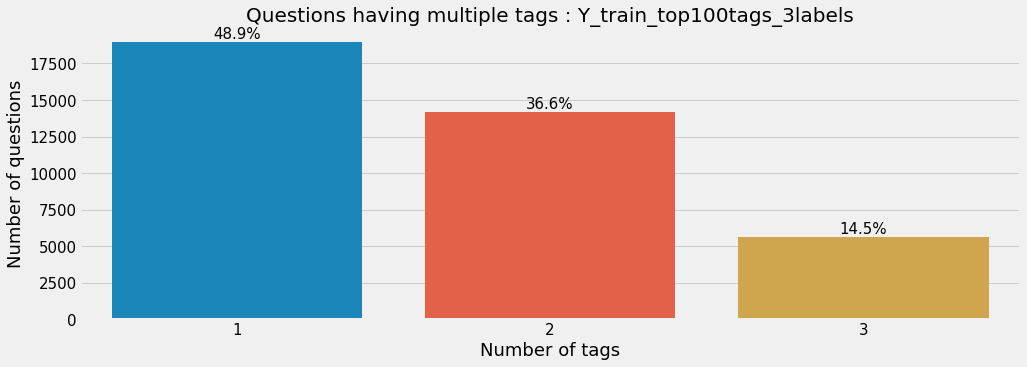

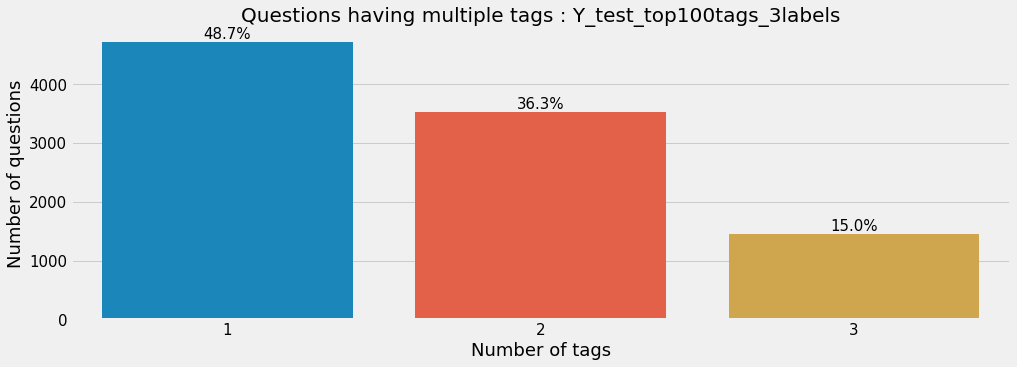

In [18]:
n_tags_by_labels(Y_train, 'Y_train_top100tags_3labels') 
n_tags_by_labels(Y_test, 'Y_test_top100tags_3labels') 

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier

dummy_clf = OneVsRestClassifier(DummyClassifier(strategy="stratified"))
dummy_clf.fit(X_tfidf_train, Y_train)

Y_pred = dummy_clf.predict(X_tfidf_test)
print(jaccard_score(Y_test, Y_pred, average='weighted'))

0.025317726073839707


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(MultinomialNB())

parameters = {
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'estimator__fit_prior' : [True, False]
}

mnb_topntags_3labels = GridSearchCV(clf, param_grid=parameters, scoring='jaccard_weighted', n_jobs=-1, verbose=3)
mnb_topntags_3labels.fit(X_tfidf_train, Y_train)

print (mnb_topntags_3labels.best_params_, mnb_topntags_3labels.best_score_)

{'estimator__alpha': 0.001, 'estimator__fit_prior': False} 0.16411298621357878


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42))

parameters = {
    'estimator__penalty': ['l1', 'l2'], 
    'estimator__C': [0.1, 1, 10, 100, 1000], 
    'estimator__class_weight': ['balanced', None]
}

lr_topntags_3labels = GridSearchCV(clf, param_grid=parameters, scoring='jaccard_weighted', n_jobs=-1, verbose=3)
lr_topntags_3labels.fit(X_tfidf_train, Y_train)

print (lr_topntags_3labels.best_params_, lr_topntags_3labels.best_score_)

In [22]:
# SAUVEGARDE
with open('lr_topntags_3labels.pkl', 'wb') as f:
    pickle.dump(lr_topntags_3labels, f)

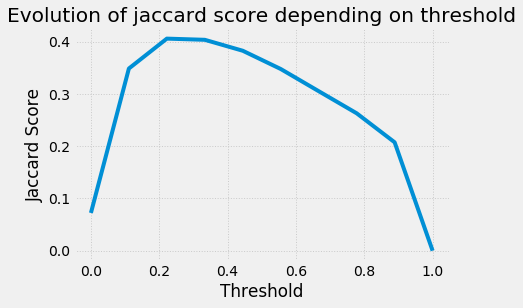

In [23]:
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

jaccard_list = []

for s in np.linspace(0, 1, 10, dtype='float'):

    Y_pred = pd.DataFrame(lr_topntags_3labels.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>s else 0).to_numpy()
    jaccard_list.append(jaccard_score(Y_test, Y_pred, average='weighted'))
                                
plt.title("Evolution of jaccard score depending on threshold", fontsize=20)
plt.xlabel("Threshold")
plt.ylabel("Jaccard Score")
plt.plot(np.linspace(0, 1, 10, dtype='float'), jaccard_list)
plt.grid(True, linestyle=":")
plt.style.use('fivethirtyeight')
plt.show()

In [24]:
Y_pred = pd.DataFrame(lr_topntags_3labels.best_estimator_.predict_proba(X_tfidf_test)).applymap(lambda x:1 if x>0.22 else 0).to_numpy()
Y_true = pd.Series(mlb.inverse_transform(Y_test))
Y_pred = pd.Series(mlb.inverse_transform(Y_pred))
display(pd.concat([Y_true, Y_pred], axis=1)[:20])

,0,1
0,"(.net, c#, winforms)","(.net, c#, winforms)"
1,"(c, java)","(c#, java)"
2,"(performance,)",()
3,"(c#,)","(.net, asp.net, c#)"
4,"(php,)",()
5,"(c#,)","(c, c#)"
6,"(forms, javascript)","(javascript,)"
7,"(.net,)","(.net, c#)"
8,"(php,)",()
9,"(winforms,)","(c#, winforms, wpf)"


# Fonction de recommandation de tags

Recommande des mots issus des analyses supervisées et non supervisées

In [25]:
from utils import clean_text, clean_punctuation, stopWordsRemove, lemmatization

# CHARGEMENT
with open('lda_model_list.pkl', 'rb') as f:
    lda_model_list = pickle.load(f)    
with open('lr_topntags_3labels.pkl', 'rb') as f:
    lr_topntags_3labels = pickle.load(f) 
with open('mlb.pkl', 'rb') as f:
    mlb = pickle.load(f) 
with open('tfidf.pkl', 'rb') as f:
    tfidf = pickle.load(f)     

posts_body_clean = pd.read_pickle("./posts_body_clean.pkl")    

In [26]:
def Recommend_tags(text_ori, n_words, mlb, tfidf, lda, clf, seuil=0.5, toptags=top500tags, clean=False):
    
    ''' Recommendation system for StackOverflow posts based on a lda model, it returns up to 5 words.

    Parameters:

    text: the stackoverflow post of user
    n_words: number of tags to recommend
    seuil: threshold for decision
    clean: True if data preparation is needed
    '''

    auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))
    with open('manual_stopwords.pkl', 'rb') as f:
        manual_stopwords = pickle.load(f) 
    with open('alltags_counter.pkl', 'rb') as f:
        alltags_counter = pickle.load(f) 
    with open('ignore_words.pkl', 'rb') as f:
        ignore_words = pickle.load(f) 
    with open('specialtags.pkl', 'rb') as f:
        specialtags = pickle.load(f)         
    
    if type(text_ori) in (str, pd.Series):
        if type(text_ori) is str:
            text_ori = pd.Series(text_ori) 
        text = text_ori
        text_ori = text_ori.rename("Texte d'origine")
        text = text.rename("Texte modifié")
    else:
        return 'Type should be str or pd.Series'

    if clean==True:
        text = text.apply(lambda s: clean_whitespace(s))
        text = text.apply(lambda s: BeautifulSoup(s).get_text())
        text = text.apply(lambda x: clean_punctuation(x, top500tags))        
        text = text.apply(lambda x: stopWordsRemove(x, auto_stopwords))
        text = text.apply(lambda x: lemmatization(x, ['NOUN'], top500tags))   
        text = text.apply(lambda x: stopWordsRemove(x, manual_stopwords))

    # document = question StackOverflow
    # word = il s'agit des mots issus du vocabulaire LDA, retenus par le LDA (max_features)
    # topic = il s'agit des topics issus du LDA (components)
    # pour chaque document et chaque mot, je calcule la probabilité totale qu'un mot apparaisse dans le document 
    # proba(word1) = proba(word1/topic1) * proba(topic1) + proba(word1/topic2) * proba(topic2) ...
    # je conserve les n_tags
    
    document_tfidf = tfidf.transform(text)
    proba_topic_sachant_document = lda.transform(document_tfidf)
    word_labels = tfidf.get_feature_names()
    proba_word_sachant_topic = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis] # normalization    
    #print(proba_topic_sachant_document.shape)    
    #print(proba_word_sachant_topic.shape)    
    
    # proba_topic_sachant_document est de dimension d x t
    # proba_word_sachant_topic est de dimension t x w
    # je peux donc opérer un produit matriciel entre les 2 matrices pour calculer pour chaque document : proba(wordn)
    # j'obtiendrai une matrice proba_word_sachant_document de dimension d x w
    # il ne me restera plus qu'à choisir les "n_words" mots les plus probables
    proba_word_sachant_document = proba_topic_sachant_document.dot(proba_word_sachant_topic)  
    
    # je transforme la matrice en dataframe : 
    # data = les proba des mots pour chaque document
    # index = l'index des données en entrée
    # columns = les labels des mots sélectionnés en sortie du LDA
    df_wd = pd.DataFrame(data=proba_word_sachant_document,
                         index=text.index,
                         columns=word_labels) 
    
    # np.argsort(-df_wd.values, axis=1)[:, :n_words])
    # renvoie pour chaque document, les "n_words" indexes des colonnes dont les proba sont les plus élevées
    # grâce aux indexes, je peux récupérer le libellé de la colonne qui est donc le libellé du mot 
    # et le stocker en ligne
    values = df_wd.columns.values[np.argsort(-df_wd.values, axis=1)[:, :n_words]]
    values = [", ".join(item) for item in values.astype(str)]
    #pred_unsupervised = pd.DataFrame(df_wd.columns.values[np.argsort(-df_wd.values, axis=1)[:, :n_words]],
    #                                 index=df_wd.index,
    #                                 columns = ['word' + str(i + 1) for i in range(n_words)])
    pred_unsupervised = pd.DataFrame(values,
                                     index=df_wd.index,
                                     columns = ['Unsupervised'])
    
    pred_supervised = pd.DataFrame(clf.predict_proba(tfidf.transform(text))).applymap(lambda x:1 if x>seuil else 0).to_numpy()
    pred_supervised = pd.Series(mlb.inverse_transform(pred_supervised), name='Supervised', index=text.index)
    pred_supervised = pred_supervised.apply(lambda row: ', '.join(row))
    result = pd.concat([pred_supervised, pred_unsupervised, text_ori, text], axis=1)
    
    return result

In [27]:
test = "this sql request grouping values by keys on the relational database is not working."
display(Recommend_tags(test, 5, mlb, tfidf, lda_model_list[4], lr_topntags_3labels.best_estimator_, seuil=0.22, clean=True))

test = "I want to develop a web application generating html, javascript and css, what is the good language to do that."
display(Recommend_tags(test, 5, mlb, tfidf, lda_model_list[4], lr_topntags_3labels.best_estimator_, seuil=0.22, clean=True))

test = "I want to code a Python function to sum item from a dictionary."
display(Recommend_tags(test, 5, mlb, tfidf, lda_model_list[4], lr_topntags_3labels.best_estimator_, seuil=0.22, clean=True))

test = posts_body_clean.loc[2:5]
display(Recommend_tags(test, 5, mlb, tfidf, lda_model_list[4], lr_topntags_3labels.best_estimator_, seuil=0.22, clean=False))
#test = X_test[:2]

,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,"database, sql","sql, database, server, mysql, table",this sql request grouping values by keys on the relational database is not working.,sql request value key database


,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,"css, html, javascript","page, javascript, html, image, jquery","I want to develop a web application generating html, javascript and css, what is the good language to do that.",web html javascript css


,Supervised,Unsupervised,Texte d'origine,Texte modifié
0,python,"python, item, line, text, iphone",I want to code a Python function to sum item from a dictionary.,python function item


,Supervised,Unsupervised,Texte d'origine,Texte modifié
2,".net, c#","table, sql, database, server, column",datetime birthday calculate age year,datetime birthday calculate age year
3,"c#, time","table, column, row, date, value",datetime value display time hour day month,datetime value display time hour day month
4,asp.net,"page, javascript, html, image, jquery",web server determine timezone web page http header agent string,web server determine timezone web page http header agent string
5,".net, c#",".net, service, web, windows, c",floor math .net,floor math .net


In [49]:
test = posts_body_clean.loc[2:5]
test

2    datetime birthday calculate age year                           
3    datetime value display time hour day month                     
4    web server determine timezone web page http header agent string
5    floor math .net                                                
Name: Body, dtype: object

In [59]:
np.mean(posts_body_clean.str.findall(r'(?u)\S+').str.len())

21.571891075218534